In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_columns = None

In [21]:
loans = pd.read_csv('./loans.w1.csv', index_col=None)

In [22]:
loans.fillna(0, inplace=True)

### Label encoding

In [23]:
from sklearn.preprocessing import LabelEncoder

In [24]:
# transform label into charged off and non-charged-off 
loans['loan_status'][loans.loan_status != 'Charged Off'] = 'Paid'

In [25]:
# function to label encoding, and output label mapping
def label_encoding(full_data, cols, label_col):
    label_mapping = {}
    for col in cols:
        print("Label encoding column: %s" % (col))
        LBL = LabelEncoder()
        LBL.fit(full_data[col])
        if col == label_col:
            label_mapping = dict(zip(full_data[label_col].unique(), LBL.transform(full_data[label_col].unique())))
            print("Label mapping: %s" % (label_mapping))
        full_data[col] = LBL.transform(full_data[col])
        
    return label_mapping

In [26]:
label_mapping = label_encoding(loans, loans.dtypes.index, 'loan_status')

Label encoding column: loan_amnt
Label encoding column: term
Label encoding column: int_rate
Label encoding column: installment
Label encoding column: grade
Label encoding column: sub_grade
Label encoding column: emp_title
Label encoding column: emp_length
Label encoding column: home_ownership
Label encoding column: annual_inc
Label encoding column: verification_status
Label encoding column: issue_d
Label encoding column: loan_status
Label mapping: {'Charged Off': 0, 'Paid': 1}
Label encoding column: pymnt_plan
Label encoding column: desc
Label encoding column: purpose
Label encoding column: title
Label encoding column: zip_code
Label encoding column: addr_state
Label encoding column: dti
Label encoding column: delinq_2yrs
Label encoding column: inq_last_6mths
Label encoding column: mths_since_last_delinq
Label encoding column: mths_since_last_record
Label encoding column: open_acc
Label encoding column: pub_rec
Label encoding column: revol_bal
Label encoding column: revol_util
Label e

In [27]:
label_mapping

{'Charged Off': 0, 'Paid': 1}

In [28]:
loans.issue_d.value_counts()

9     14536
6     12711
3      9466
4      9041
0      8620
2      8470
10     8448
7      7973
1      7909
5      7764
8      4242
11     3270
Name: issue_d, dtype: int64

### Train and Test split

In [29]:
loans_y = loans['loan_status']
loans_X = loans.drop('loan_status', axis=1)
print loans_X.shape, loans_y.shape

(102450, 92) (102450,)


In [30]:
len(loans_X[loans_X.issue_d <= 10])

99180

In [31]:
loans_X[loans_X.issue_d <= 10].drop('issue_d', axis=1, inplace=True)

In [32]:
# use 1-10 as train data, 11, 12 as test data
X_train = loans_X[loans_X.issue_d <= 10].drop('issue_d', axis=1, inplace=False)
y_train = loans_y[loans_X.issue_d <= 10]
print X_train.shape, y_train.shape

(99180, 91) (99180,)


In [33]:
X_vali = loans_X[loans_X.issue_d > 10].drop('issue_d', axis=1, inplace=False)
y_vali = loans_y[loans_X.issue_d > 10]
print X_vali.shape, y_vali.shape

(3270, 91) (3270,)


### Assumptions of Logistic regression
http://www.statisticssolutions.com/assumptions-of-logistic-regression/

__Assumptions:__
    
- Binary logistic regression requires the dependent variable to be binary and ordinal logistic regression requires the dependent variable to be ordinal. 
- Since logistic regression assumes that P(Y=1) is the probability of the event occurring, it is necessary that the dependent variable is coded accordingly. sklearn pakcage has already taken care of this.
- The model should be fitted correctly.  That is not only the meaningful variables should be included, but also all meaningful variables should be included. A good approach to ensure this is to use a stepwise method to estimate the logistic regression, or we could use L1 to penalize the model.
- Each observation need to be independent.
- Lastly, it requires quite large sample sizes.

__Model Tuning:__ 
 
- L1 norm, penalize the sum of absolute weights, control the balance of fit and sparsity. Higher l1, sparser model, lower l1, more dense model.

- L2 norm, penalize the sume of squared weights, control the balance of fit and coefficient magnitude. Higher l2, smaller weights and less tendency to overfitting; lower l2, higher weights and more tendency to overfitting.

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [35]:
lgr = LogisticRegression(penalty='l2', random_state=101)
lgr = lgr.fit(X_train, y_train)
preds = lgr.predict(X_vali)
score = roc_auc_score(y_vali, preds)
print score

0.539631834805


In [36]:
from sklearn.linear_model import ElasticNet
from sklearn.grid_search import GridSearchCV

In [37]:
def alpha_search(train_X, train_y, test_X, test_y, alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000, 10000]):
    for a in alpha:
        elasticNet = ElasticNet(alpha=a)
        elasticNet.fit(train_X, train_y)
        pred = elasticNet.predict(test_X)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        print "alpha {} :     score: {}".format(a, roc_auc)

In [38]:
alpha_search(X_train, y_train, X_vali, y_vali)

alpha 1e-05 :     score: 0.762051036185
alpha 0.0001 :     score: 0.762103687846
alpha 0.001 :     score: 0.762273412026
alpha 0.1 :     score: 0.754113643346
alpha 1 :     score: 0.745516246444
alpha 10 :     score: 0.700131443325
alpha 100 :     score: 0.637443136206
alpha 1000 :     score: 0.558772572077
alpha 10000 :     score: 0.5


In [40]:
elasticNet = ElasticNet(alpha=0.001)
elasticNet.fit(X_train, y_train)
preds = elasticNet.predict(X_vali)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_vali, preds)
roc_auc = auc(false_positive_rate, true_positive_rate)

### Plot the roc curve

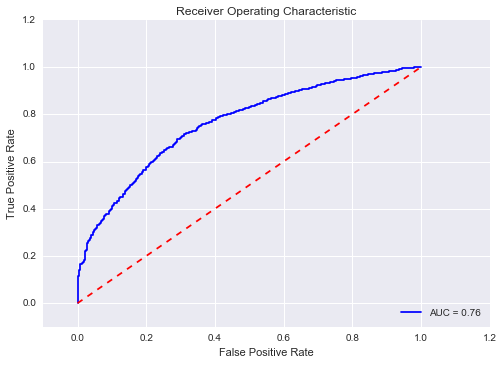

In [41]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()